In [1]:
# !pip install pyspark -qqq
!pip install -U kaleido

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, DateType

'''

Создадим пример данных для таблиц EMPLOYEE, DEPARTAMENT

'''

# Create a Spark session
spark = SparkSession.builder.getOrCreate()

'''

Create Departament Table

'''

# Sample data for the Department table
data = [
        (1, "Business"),
        (2, "Analytics")]

# Define the schema for the Department table
schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("NAME", StringType(), True),
])

# Create a DataFrame for the Department table
departament = spark.createDataFrame(data, schema)
departament.createOrReplaceTempView("DEPARTAMENT")

'''

Create Employee Table

'''

# Sample data for the Department table
data = [
        (1,1,None,"Тамара",100000.0),
        (2,2,3,"Наташа",150000.0),
        (3,2,None,"Давид",110000.0),
        (4,1,1, "Александр",70000.0),
        (5,2,3,"Павел",200000.0),
        (6,1,1,"Михаил",50000.0),
         (7,1,1,"Екатерина",90000.0)]

# chief 1 : Tamara, chief 2 : David

# Define the schema for the Department table
schema = StructType([
    StructField("ID", IntegerType(), True),
    StructField("DEPARTAMENT_ID", IntegerType(), True),
    StructField("CHIEF_ID", IntegerType(), True),
    StructField("NAME", StringType(), True),
    StructField("SALARY", FloatType(), True)
])

# Create a DataFrame for the Department table
employee = spark.createDataFrame(data, schema)
employee.createOrReplaceTempView("EMPLOYEE")

In [5]:
# 1) Вывести список сотрудников, получающих зароботную плату больше чем у руководителя

# Ход мышления:
# - Нам нужно сравнить данные внутри таблицы; создадим дубликат и соеденим с JOIN
# - Добавим условие которое говорит о том что salary должно быть меньше чем у руководителя

query1 = """
SELECT e2.NAME
FROM EMPLOYEE e1
INNER JOIN EMPLOYEE e2 ON e1.ID = e2.CHIEF_ID
WHERE e1.SALARY < e2.SALARY
"""

# Now you can use SQL to query the table
spark.sql(query1).show()

+------+
|  NAME|
+------+
|Наташа|
| Павел|
+------+



In [8]:
# 2) Вывести список сотрудников, получающих максимальную зароботную плату в своем отделе

# Ход мышления:
# - Надо найти максимальное значение для всех отделов, можно воспользоватся
#   WHERE с условие двух атрибут чтобы было точное совпадение с DEPARTAMENT и MAX SALARY

query2 = """
SELECT
       EMPLOYEE.NAME,
       EMPLOYEE.DEPARTAMENT_ID,
       EMPLOYEE.SALARY
FROM EMPLOYEE
WHERE
    (DEPARTAMENT_ID, SALARY) IN (SELECT DEPARTAMENT_ID,MAX(SALARY)
                                  FROM EMPLOYEE
                                  GROUP BY DEPARTAMENT_ID)
"""

spark.sql(query2).show()

+------+--------------+--------+
|  NAME|DEPARTAMENT_ID|  SALARY|
+------+--------------+--------+
|Тамара|             1|100000.0|
| Павел|             2|200000.0|
+------+--------------+--------+



In [10]:
# 3) Вывести список ID отделов, количество сотрудников в которых не превышает 3 человека

# Ход мышления:
# - В этот раз нам нужно обратится к DEPARTAMENT и привязать условие для выбора ID используя WHERE
#   для условия мы обратимся с EMPLOYEE и посчитаем количество сотрудников с SUM
#   добавив условие для GROUP BY с HAVING при группированаия по отделам

query3 = """
SELECT NAME
FROM DEPARTAMENT
WHERE ID IN (SELECT DEPARTAMENT_ID
             FROM EMPLOYEE
             GROUP BY DEPARTAMENT_ID
             HAVING COUNT(*) > 2)
"""

spark.sql(query3).show()

+---------+
|     NAME|
+---------+
| Business|
|Analytics|
+---------+



In [11]:
# 4) Вывести список сотрудников, не имеющих назначенного руководителя, работующего в том же отделе

query4 = """
WITH COMBINED AS (
                    SELECT
                        e.NAME AS WORKER,
                        e2.NAME AS CHIEF,
                        d.NAME AS DEPARTAMENT
                    FROM EMPLOYEE e
                    JOIN EMPLOYEE e2 ON e.chief_id = e2.ID
                    JOIN DEPARTAMENT d ON e.DEPARTAMENT_ID = d.ID
                  )

SELECT *
FROM COMBINED
WHERE CHIEF IS NULL
"""

spark.sql(query4).show()

+------+-----+-----------+
|WORKER|CHIEF|DEPARTAMENT|
+------+-----+-----------+
+------+-----+-----------+



In [13]:
# 5) Найти список ID отделов с максимальной суммарной зарплатой сотрудников

# Ход мышления:
# - Найти список ID отделов с максимальной суммарной зарплатой сотрудников

tquery = """
-- максимальное salary в department_id
WITH DEP_MAX AS (SELECT DEPARTAMENT_ID,
                        SUM(SALARY) AS SALARY
                    FROM EMPLOYEE
                    GROUP BY DEPARTAMENT_ID)

-- Выводим ID department где salary равно max(SALARY)
SELECT DEPARTAMENT_ID
FROM DEP_MAX
WHERE DEP_MAX.SALARY = (SELECT max(SALARY)
                        FROM DEP_MAX);
"""

spark.sql(tquery).show()

+--------------+
|DEPARTAMENT_ID|
+--------------+
|             2|
+--------------+



In [ ]:
'''

Необходимо дополнить структуру новыми данными в связи с задачей фиксации отработанного времени.

Условия:
- Каждый сотрудник работает в своем часовом поясе, который явно прописан и не меняется.
  Стандартный график 8 часов с 9 утра по его часовому поясу (Обед пропускаем в рамках данной задачи)
- Работник к концу недели должен заполнить количество отработанных часов для каждого дня.
  Отсутствие часов означает отсутствие сотрудника на рабочем месте.

Необходимо разработать скрипты для обновления базы данных и разработать аналитический отчет,
который позволит отследить количество сотрудников для каждого часа рабочей недели.
Допускается выводить 0 сотрудников.

'''

# Ход мышления:
# - Для этой задачи воспользуемся postgres и для автоматизации будем использовать python
#   вместе с библиотекой psycopg2 для работы с СУБД
# - БД создается локально поэтом при необходимости данные из выгрузки испортируется в colab

import psycopg2
from datetime import date, datetime, timedelta

In [ ]:
# создаем пример данных, как и для spark

conn = psycopg2.connect(database = "postgres",
                        user = "postgres",
                        port = 5433)

'''

CREATE TABLE

'''

# Open a cursor to perform database operations
cur = conn.cursor()
# Execute a command: create datacamp_courses table
cur.execute("""
CREATE TABLE DEPARTMENT (
    ID INT,
    NAME VARCHAR(100));

CREATE TABLE EMPLOYEE (
    ID INT PRIMARY KEY,
    DEPARTMENT_ID INT,
    CHIEF_ID INT,
    NAME VARCHAR(100),
    SALARY INT);
""")

conn.commit()
cur.close()

In [ ]:
'''

ADD DATA TO TABLES

'''

cur = conn.cursor()
cur.execute("""
    INSERT INTO EMPLOYEE (ID,DEPARTMENT_ID,CHIEF_ID,NAME,SALARY) VALUES (1,1,NULL,'Тамара',100000),
                                                                        (2,2,3,'Наташа',150000),
                                                                        (3,2,NULL,'Давид',110000),
                                                                        (4,1,1, 'Александр',70000),
                                                                        (5,2,3,'Павел',200000),
                                                                        (6,1,1,'Михаил',50000),
                                                                        (7,1,1,'Екатерина',90000)""")

cur.execute("""
                    INSERT INTO DEPARTMENT (ID,NAME) VALUES (1,'Business'),
                                                             (2,'Analytics')
                                                             """)

cur.close()
conn.commit()

In [ ]:
# тепер имея информацию о том что нужно добавить еще данные о пользовате
# добавим его через ALTER TABLE

'''

[step 1] : ADD employee_id timezones

'''

# add new column to account for timezones
cur = conn.cursor()
cur.execute("""
              ALTER TABLE EMPLOYEE
              ADD TIMEZONE VARCHAR(50)
             """)
cur.close()
conn.commit()

In [ ]:
'''

[step 2] : ADD employee_id timezones

'''

# Добавляем собранную информацию в таблицу EMPLOYEE

conn = psycopg2.connect(database = "postgres",
                        user = "postgres",
                        port = 5433)

# say we store data in dictionaries (lists are just used for convenience)
timezone =  ["UTC+3","UTC-5","UTC+3","UTC+3","UTC+3","UTC-5","UTC-5"]
ids = [i for i in range(1,8)]
new_data = dict(zip(ids,timezone))

# update each row in the
cur = conn.cursor()
for ii,i in enumerate(new_data.items()):
    cur.execute(f"UPDATE EMPLOYEE SET TIMEZONE = '{timezone[ii]}' WHERE ID = {ids[ii]}")

cur.close()
conn.commit()

In [ ]:
'''

CREATE NEW TABLE FOR WORKING HOURS

    add constraint to table to prevent user from adding duplicate entries
    for a particular combination of (employee_id,date)

'''

# теперь нам нудно добавить новую таблицу в которую сотрудники будут
# добавлять количество проработанных часов
# эдинственный важный момент это добавления CONTRAINT для того чтобы
# сотрудник дважды не вводил ту же информацию

conn = psycopg2.connect(database = "postgres",
                        user = "postgres",
                        port = 5433)

cur = conn.cursor()
cur.execute("""
                    CREATE TABLE WORKED_HOURS (
                        EMPLOYEE_ID INT,
                        DATE DATE,
                        HOURS_WORKED INT,
                        START_TIME TIMESTAMP,
                        END_TIME TIMESTAMP,
                        CONSTRAINT pk_employee_date PRIMARY KEY (employee_id, date)
                        )
             """)
cur.close()
conn.commit()

In [15]:
'''

Теперь главный класс для фунционала работы с WORKED_HOURS

[weekly_info] : дает пользователю dict с датами этой недели, которую он заполняет
                это на случае если сотрудник только один раз заполняет табель в конце недели

                Пример return:
                {'2023-12-25': None, '2023-12-26': None, '2023-12-27': None, '2023-12-28': None, '2023-12-29': None}

[store_hours] : дает пользователю возможность загрузить данные dict в WORKED_HOURS

                Пример:

                        # Пользователь вводит в бд количество рабочих часов

                        weekly_data['2023-12-25'] = 8
                        weekly_data['2023-12-26'] = 8
                        weekly_data['2023-12-27'] = 8
                        weekly_data['2023-12-28'] = 8
                        weekly_data['2023-12-29'] = 8

                        store_data.store_hours(1,weekly_data)  # store weekly data

                При необходимости пользователь может коректировать вводную dict и опять
                обновлять бд

[reset_weeklyhours] : удаляет информацию для работника (на этой недели)!

[store_today] : При необходимость пользователь может отчитоватся каждый день

[extract_weekly_data] : Для отчетности для

    ""
    разработать аналитический отчет
    который позволит отследить количество сотрудников для каждого часа рабочей недели.
    Допускается выводить 0 сотрудников.
    ""

Постановка задачи немного не ясная, но интерпретируется так: используя слово "отследить"
и добавление иформации о временном поясе намикает на то что нужно совместить все пояса
в один пояс для того чтобы один пользователь мог понять сколько работниуов присутствовали
на работе в эго временном поясе (предположим что это UTC+0)

        пример из выгрузки:

        [
        (datetime.datetime(2023, 12, 25, 0, 0), 0)
        (datetime.datetime(2023, 12, 25, 1, 0), 0)
        (datetime.datetime(2023, 12, 25, 2, 0), 0)
        (datetime.datetime(2023, 12, 25, 3, 0), 0)
        (datetime.datetime(2023, 12, 25, 4, 0), 0)
        (datetime.datetime(2023, 12, 25, 5, 0), 0)
        (datetime.datetime(2023, 12, 25, 6, 0), 4)
        (datetime.datetime(2023, 12, 25, 7, 0), 4)
        (datetime.datetime(2023, 12, 25, 8, 0), 4)
        (datetime.datetime(2023, 12, 25, 9, 0), 3)
        (datetime.datetime(2023, 12, 25, 10, 0), 3)
        (datetime.datetime(2023, 12, 25, 11, 0), 1)
        ...]

Комментарии следуют в самом методе

'''

conn = psycopg2.connect(database = "postgres",
                        user = "postgres",
                        port = 5433)

class store_working_hours:

    def __init__(self):
        pass

    '''

    Show weekly dictionary

        generates and returns weekly dictionary, which users fill out and return
        into store_hours

    '''

    def weekly_info(self):
        current_date = datetime.today() # # Get current date
        start_date = current_date - timedelta(days=current_date.weekday()) # monday
        end_date = start_date + timedelta(days=4) # friday

        # Print the dates from Monday to Friday
        lst = ['monday','tuesday','wednesday','thursday','friday']; counter = 0
        lst_dates = []; print('')
        while start_date <= end_date:
            lst_dates.append(start_date.strftime("%Y-%m-%d"))
            start_date += timedelta(days=1)
            counter += 1

        return {key: None for key in lst_dates}

    '''

    Store Weekly Hours

        requires employee_id : [int]
           "     weekly_hours : [dict]



    '''

    def store_hours(self,employee_id:int,weekly_hours:dict):

        try:
            ints_cond = all(isinstance(value, int) for value in weekly_hours.values())
        except:
            print('all values need to be integers')
            ints_cond = False

        # store the date into the database if all entries have been filled out & are integers

        if(ints_cond):

            try:

                conn = psycopg2.connect(database = "postgres",
                                        user = "postgres",
                                        port = 5433)
                cur = conn.cursor()

                # add new entry or modify current entry
                for date,hours in weekly_hours.items():

                    # define start and final time
                    current_date = datetime.now().date(); start_time = '9:00 AM'
                    start_datetime_str = str(date) + ' ' + start_time
                    start_datetime = datetime.strptime(start_datetime_str, '%Y-%m-%d %I:%M %p')
                    final_datetime = start_datetime + timedelta(hours=hours)

                    query = f"""INSERT INTO WORKED_HOURS (EMPLOYEE_ID,DATE,HOURS_WORKED,START_TIME,END_TIME) VALUES ({employee_id}, '{date}', {hours}, '{start_datetime}', '{final_datetime}')"""
                    cur.execute(query)
                    cur.close()
                    conn.commit()

            except:

                # reset user's weekly hours
                self.reset_weeklyhours(employee_id)

                conn = psycopg2.connect(database = "postgres",
                                        user = "postgres",
                                        port = 5433)
                cur = conn.cursor()

                # add new entry or modify current entry
                for date,hours in weekly_hours.items():

                    # define start and final time
                    current_date = datetime.now().date(); start_time = '9:00 AM'
                    start_datetime_str = str(date) + ' ' + start_time
                    start_datetime = datetime.strptime(start_datetime_str, '%Y-%m-%d %I:%M %p')
                    final_datetime = start_datetime + timedelta(hours=hours)

                    query = f"""INSERT INTO WORKED_HOURS (EMPLOYEE_ID,DATE,HOURS_WORKED,START_TIME,END_TIME) VALUES ({employee_id}, '{date}', {hours}, '{start_datetime}', '{final_datetime}')"""
                    cur.execute(query)

                cur.close()
                conn.commit()

    '''

    Delete all entries from Database for employee_id

        requires employee_id : [int]

    '''

    def reset_weeklyhours(self,employee_id:int):

        conn = psycopg2.connect(database = "postgres",
                                user = "postgres",
                                port = 5433)
        cur = conn.cursor()

        # generate weekly
        current_date = datetime.today() # # Get current date
        start_date = current_date - timedelta(days=current_date.weekday()) # monday
        end_date = start_date + timedelta(days=4) # friday

        # Print the dates from Monday to Friday for this week
        lst = ['monday','tuesday','wednesday','thursday','friday']; counter = 0
        lst_dates = [];
        while start_date <= end_date:
            lst_dates.append(start_date.strftime("%Y-%m-%d"))
            start_date += timedelta(days=1)

        # delete from database all the relevant entries
        for date in lst_dates:
            query = f"DELETE FROM WORKED_HOURS WHERE EMPLOYEE_ID = {employee_id} AND DATE = '{str(date)}'"
            cur.execute(query)
            conn.commit()

    '''

    Stores the number of hours a user has worked today

        requires employee_id : [int]
                  hours      : [int]

    '''

    def store_today(self,employee_id:int,hours:int):

        conn = psycopg2.connect(database = "postgres",
                                user = "postgres",
                                port = 5433)
        cur = conn.cursor()

        # define start and final time
        current_date = datetime.now().date()
        start_time = '9:00 AM'

        start_datetime_str = str(current_date) + ' ' + start_time
        start_datetime = datetime.strptime(start_datetime_str, '%Y-%m-%d %I:%M %p')
        final_datetime = start_datetime + timedelta(hours=hours)

        query = f"SELECT COUNT(*) FROM WORKED_HOURS WHERE EMPLOYEE_ID = {employee_id} AND DATE = '{str(current_date)}'"
        cur.execute(query)
        data = cur.fetchall()[0][0]

        if(data == 0):
            # add new entry or modify current entry
            query = f"""INSERT INTO WORKED_HOURS (EMPLOYEE_ID,DATE,HOURS_WORKED,START_TIME,END_TIME) VALUES ({employee_id}, '{str(current_date)}', {hours}, '{start_datetime}', '{final_datetime}')"""
            cur.execute(query)
            cur.close()
            conn.commit()
        else:
            # modify existing entry
            print('already in database, updating information!')
            query = f"UPDATE WORKED_HOURS SET END_TIME = '{final_datetime}', HOURS_WORKED = {hours} WHERE EMPLOYEE_ID = {employee_id} AND DATE = '{str(current_date)}'"
            cur.execute(query)
            conn.commit()

    '''

    Extracts the employees present for a given period

        requires start_date : [str]
                  end_date  : [str]

        returns list of rows data : [list]

    '''

    def extract_weekly_data(self,start_date:str,end_date:str):

        conn = psycopg2.connect(database = "postgres",
                                user = "postgres",
                                port = 5433)
        cur = conn.cursor()

        query = f"""
                    -- Создадим календарь для start_date + 120 часов (mon-fri)
                    WITH calendar AS (
                        SELECT '{start_date} 00:00:00'::timestamp + value * interval '1 hour' AS cal_date
                        FROM generate_series(0, 120, 1) AS value
                    ),

                    -- Добавим TIMEZONE, и конвертируем локальное время на относительное время, например для
                    -- работника находящийся в поясе UTC
                    combined AS (
                    SELECT
                      wh.EMPLOYEE_ID,
                      e.NAME,
                      wh.DATE,
                      (wh.START_TIME AT TIME ZONE 'UTC') AT TIME ZONE e.TIMEZONE AS START_TIME,
                      (wh.END_TIME AT TIME ZONE 'UTC') AT TIME ZONE e.TIMEZONE AS END_TIME
                    FROM
                      WORKED_HOURS wh
                    JOIN EMPLOYEE e ON e.ID = wh.EMPLOYEE_ID
                    WHERE DATE BETWEEN '{start_date}' AND '{end_date}'
                    )

                    -- найдем пересечение календаря с рабочим временем используя BETWEEN и AND и сгруппируем уникальные значения
                    SELECT cal_date, COUNT(DISTINCT EMPLOYEE_ID) AS headcount
                    FROM      calendar
                    LEFT JOIN combined c
                           ON calendar.cal_date BETWEEN c.start_time AND c.end_time
                    GROUP BY cal_date
                """

        cur.execute(query)
        data = cur.fetchall()
        return data   # can be converted straight into dataframe

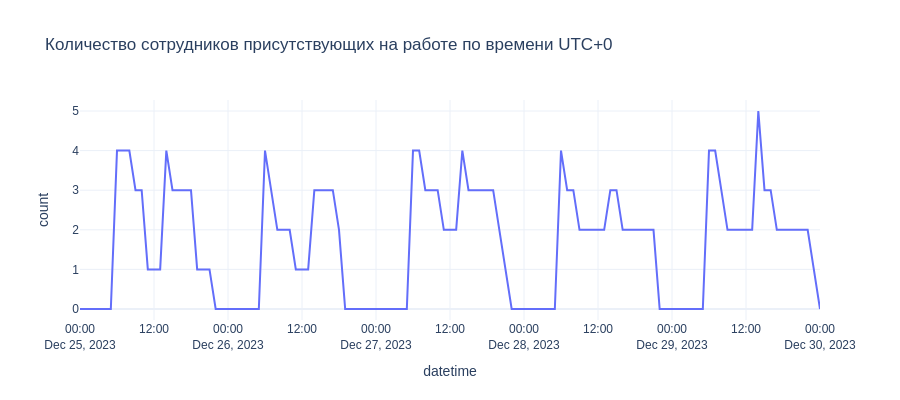

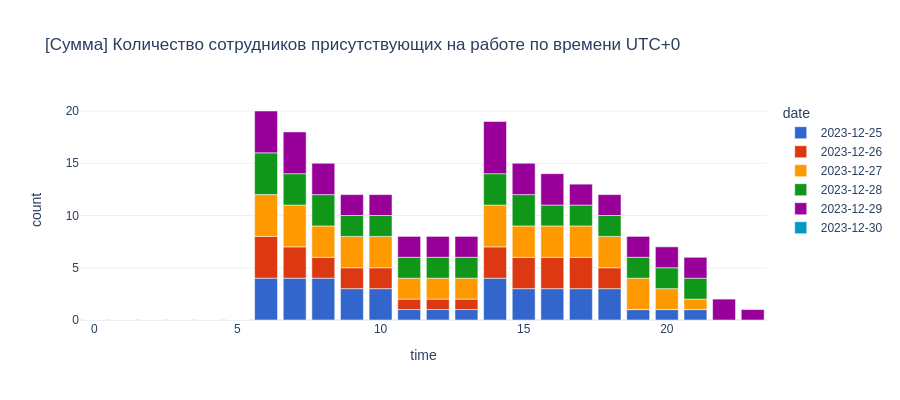

In [2]:
'''

For Analysis for working hours

'''

import plotly.express as px
import pandas as pd

# instantiate class
# store_data = store_working_hours()
# lst_date = store_data.extract_weekly_data('2023-12-25','2023-12-29')
# df = pd.DataFrame(lst_date,columns=['datetime','count'])
# df['date'] = df['datetime'].dt.date
# df['time'] = df['datetime'].dt.hour
df = pd.read_csv('temp.csv')
# df.to_csv('temp.csv',index=False)

# Количество сотрудников присутствующих на работе по времени UTC+0
fig = px.line(df,x='datetime',y='count',template='plotly_white',width=900,height=400,
       title='Количество сотрудников присутствующих на работе по времени UTC+0')
fig.show("png")

# + Сумма присутствующих за неделю
fig = px.bar(df,x='time',y='count',template='plotly_white',width=900,height=400,color='date',
       color_discrete_sequence=px.colors.qualitative.G10,
       title='[Сумма] Количество сотрудников присутствующих на работе по времени UTC+0')
fig.show("png")

In [5]:
# df.drop(['datetime'],axis=1,inplace=True)
df = df.reindex(columns=['date', 'time', 'count'])
df = df.rename(columns={'date': 'Дата', 'time': 'Время', 'count': 'Количество сотрудников'})
display(df)

,Дата,Время,Количество сотрудников
0,2023-12-25,0,0
1,2023-12-25,1,0
2,2023-12-25,2,0
3,2023-12-25,3,0
4,2023-12-25,4,0
...,...,...,...
116,2023-12-29,20,2
117,2023-12-29,21,2
118,2023-12-29,22,2
119,2023-12-29,23,1
